### Setup

In [231]:
import os, sys
sys.path.append('..')

from cobra import io
from cobra.core import Model, Reaction, Gene, GPR
from cobra.manipulation import remove_genes
from scripts.helpers.model import rxn_in_model, gene_in_model
# Load models

# Load wildtype from manual directory (adjust path for notebooks directory)
# Use io.read_sbml_model for local files instead of io.load_model
wildtype = io.read_sbml_model('../data/fill/xmls/MNL_iCre1355_auto_GAPFILL.xml')

models = {
    "Wildtype": wildtype
}

# Get altered reactions of wildtype - using correct directory name
altered_dir = '../data/altered/xmls/MNL_iCre1355_auto_GAPFILL/'

for root, dirs, files in os.walk(altered_dir):

    # Exclude the /h directory from search
    if root.endswith('/h'):
        continue

    for file in files:
        if file.endswith('.xml'):
            # Get file name and remove .xml extension
            model_name = file[:-4]
            full_path = os.path.join(root, file)
            print(f"Loading model: {model_name} from {full_path}")
            models[model_name] = io.read_sbml_model(full_path)

No objective coefficients in model. Unclear what should be optimized


Loading model: SQE+MVA from ../data/altered/xmls/MNL_iCre1355_auto_GAPFILL/SQE+MVA.xml


No objective coefficients in model. Unclear what should be optimized


Loading model: SQE from ../data/altered/xmls/MNL_iCre1355_auto_GAPFILL/SQE.xml


No objective coefficients in model. Unclear what should be optimized


Loading model: SQS+MVA from ../data/altered/xmls/MNL_iCre1355_auto_GAPFILL/SQS+MVA.xml


No objective coefficients in model. Unclear what should be optimized


Loading model: SQS+SQE+MVA from ../data/altered/xmls/MNL_iCre1355_auto_GAPFILL/SQS+SQE+MVA.xml


No objective coefficients in model. Unclear what should be optimized


Loading model: SQS+SQE from ../data/altered/xmls/MNL_iCre1355_auto_GAPFILL/SQS+SQE.xml


No objective coefficients in model. Unclear what should be optimized


Loading model: SQS from ../data/altered/xmls/MNL_iCre1355_auto_GAPFILL/SQS.xml


No objective coefficients in model. Unclear what should be optimized


In [232]:
mode = {
    # 'sqe': 'Saccharomyces cerevisiae',
    'sqe': 'Botryococcus braunii',
    'sqs': 'Saccharomyces cerevisiae',
    # 'sqs': 'Thermosynechococcus vestitus',
    'iter': '4'
}

### Uniprot Gene IDs

In [233]:
"""
The following reactions need to have gene associations updated to UniProt IDs for GECKO Kcat values:
    - ALT_MVAS, ALT_MVAD, ALT_MVAE, ALT_MVD, ALT_MVK, ALT_PMK, ALT_IDLI (MVA pathway)
    - SS, SMO, ERG5, ERG3, ERG (Sterol pathway)
    - ALT_PSPPS2, ALT_SQS2, ALT_SQE2 (Overexpressions)
    - DXS, CMK, CMS, HDS (MEP pathway)
    - Additional SQS, SQE strains with their kcat values

Concepts to keep in mind:
    - One gene may regulate multiple reactions
    - One reaction may be regulated by the conjunction or disjunction of multiple genes

Ensure:
    - Did we cover ever necessary reaction for proper constraining?
"""
reac_gene = {
    # MVA Pathway -- Note: what strain are we using for MVA?
    'ALT_MVAS': ['MVAS'],
    'ALT_MVAD': ['MVAD'],
    'ALT_MVAE': ['MVAE'],
    'ALT_MVK': ['MVK'],
    'ALT_PMK': ['PMK'],
    'ALT_IDLI': ['IDLI'],
    # MEP Pathway
    'DXS': ['Cre07.g356350.t1.1'],
    'CMK': ['Cre02.g145050.t1.2'],
    'CMS': ['Cre16.g679669.t1.1'],
    'HDS': ['Cre12.g490350.t1.1'],
    # Sterol Pathway
    'SS': ['Cre03.g175250.t1.2', 'Cre03.g175250.t2.1'],
    'SMO': ['Cre17.g734644.t1.1'],
    'ERG5': ['ERG5'],
    'ERG3': ['ERG3'],
    'ERG': ['ERG4'],
    # Overexpressions
    'ALT_PSPPS2': ['SQS2'],
    'ALT_SQS2': ['SQS2'],
    'ALT_SQE2': ['SQE2'],
}

gene_uniprot = {
    # MVA Pathway
    'MVAS': 'Q9FD71', # https://www.uniprot.org/uniprotkb/Q9FD71/entry
    'MVAE': 'Q9FD65', # https://www.uniprot.org/uniprotkb/Q9FD65/entry
    'MVK': 'Q8PW39', # https://www.uniprot.org/uniprotkb/Q8PW39/entry
    'PMK': 'Q04430', # https://www.uniprot.org/uniprotkb/Q04430/entry
    'MVAD': 'P32377', # https://www.uniprot.org/uniprotkb/P32377/entry
    # MEP Pathway
    'Cre07.g356350.t1.1': 'O81954', # https://www.uniprot.org/uniprotkb/O81954/entry
    'Cre02.g145050.t1.2': 'O81014', # https://www.uniprot.org/uniprotkb/O81014/entry (assumes CMK/ISPE of Arabidopsis thaliana)
    # Sterol Pathway
    'Cre03.g175250.t1.2': 'B4DWP0', # https://www.uniprot.org/uniprotkb/B4DWP0/entry (assumes sqs of homo sapiens)
    'Cre03.g175250.t2.1': 'B4DWP0', # ... (likewise)
    'Cre17.g734644.t1.1': 'P52020', # https://www.uniprot.org/uniprotkb/P52020/publications (assumes sqe of rattus norvegicus)
}

# Overexpressions
gene_uniprot['SQE2'] = 'P32476' if mode['sqe'] == 'Saccharomyces cerevisiae' else 'A0A0E4FJ73'
gene_uniprot['SQS2'] = 'P29704' if mode['sqs'] == 'Saccharomyces cerevisiae' else 'DUMMY3'

kcat_database = {
    'Q9FD71': 1,       # MVAS - 3-hydroxy-3-methylglutaryl-CoA synthase (Via's Notebook)
    'O81954': 2.6,     # DXS - 1-deoxy-D-xylulose-5-phosphate synthase (assumes E. coli)
    'P52020': 0.683,   # SMO - Sterol 14α-demethylase
    'P29704': 0.53,    # SQS2 - Squalene synthase (Saccharomyces cerevisiae)
    'DUMMY3': 1.74,    # SQS2 - Squalene synthase (Thermosynechococcus vestitus)
    'P32476': 3.2442,     # SQE2 - Squalene epoxidase (Saccharomyces cerevisiae) (DL-Kcat used)
    'A0A0E4FJ73': 17.7006, # SQE2 - Squalene epoxidase (Botryococcus braunii) (DL-Kcat used)
}

# Enzyme availability
enzyme_availability = {
    'O81954': 0.0020,   # DXS
    'P52020': 0.0002,  # SMO
    # New
    'Q9FD71': 0.0020,   # MVAS
    'P29704': 0.0003,    # SQS2 - Saccharomyces cerevisiae
    'DUMMY3': 0.0003,    # SQS2 - Thermosynechococcus vestitus
    'P32476': 0.0002,    # SQE2 - Saccharomyces cerevisiae
    'A0A0E4FJ73': 0.0002 # SQE2 - Botryococcus braunii
}

'''
NOTE: SMILE notation for compounds in DLKcat model are as follows.
Squalene - https://pubchem.ncbi.nlm.nih.gov/compound/Squalene
'''

'\nNOTE: SMILE notation for compounds in DLKcat model are as follows.\nSqualene - https://pubchem.ncbi.nlm.nih.gov/compound/Squalene\n'

The following script rebuilds the model gene associations where the above stated gene ids are replaced with the uniprot equivalent:

In [234]:
def rxns_with_gene(m: Model, gene_id: str) -> list[Reaction]:

    return [rxn for rxn in m.reactions if gene_id in list(map(lambda x: x.id, rxn.genes))]

def rebuild_model(m: Model) -> Model:

    new_model: Model = m.copy()

    removal: list[Gene] = []
    
    for gene in new_model.genes:

        if gene.id not in gene_uniprot.keys(): continue

        # # Special handling for this case
        # if gene.id in ['SQS2', 'SQE2']:
        #     continue
        
        old_gid = gene.id
        new_gid = gene_uniprot[old_gid]
        
        # If new_gid is empty, skip
        if new_gid == "": continue

        # If new_gid already in model, mark current gene for removal and skip
        if gene_in_model(new_model, new_gid):
            removal.append(gene)
            continue
        
        gene.id = new_gid

        print(f"New gene: {new_gid} (old: {old_gid})")
        # Find all reactions that are associated with the gene and update the gpr / gene_reaction
        rxns = rxns_with_gene(new_model, gene.id)
        for rxn in rxns:
            print(f"\t{rxn.id} --- {rxn.gene_reaction_rule}")
            if old_gid in rxn.gene_reaction_rule:
                rxn.gene_reaction_rule = rxn.gene_reaction_rule.replace(old_gid, new_gid)
                if rxn.gene_reaction_rule.count(new_gid) > 1:
                    rxn.gene_reaction_rule = new_gid
                # rxn.gene_reaction_rulue = new_gid

    for rgene in removal:
        print(f"Removing duplicate gene: {rgene.id}")
        remove_genes(new_model, [rgene], remove_reactions=False)
    print('\n')
    
    return new_model

# Models updated with UniProt IDs
updated_models = {k: rebuild_model(v) for k, v in models.items()}

New gene: P52020 (old: Cre17.g734644.t1.1)
	SMO --- Cre17.g734644.t1.1
New gene: O81014 (old: Cre02.g145050.t1.2)
	CMK --- Cre02.g145050.t1.2
New gene: O81954 (old: Cre07.g356350.t1.1)
	DXS --- Cre07.g356350.t1.1
New gene: B4DWP0 (old: Cre03.g175250.t2.1)
	PSPPS --- Cre03.g175250.t1.2 or Cre03.g175250.t2.1
	SS --- Cre03.g175250.t1.2 or Cre03.g175250.t2.1
Removing duplicate gene: Cre03.g175250.t1.2


New gene: P52020 (old: Cre17.g734644.t1.1)
	SMO --- Cre17.g734644.t1.1
New gene: O81014 (old: Cre02.g145050.t1.2)
	CMK --- Cre02.g145050.t1.2
New gene: O81954 (old: Cre07.g356350.t1.1)
	DXS --- Cre07.g356350.t1.1
New gene: B4DWP0 (old: Cre03.g175250.t2.1)
	PSPPS --- Cre03.g175250.t1.2 or Cre03.g175250.t2.1
	SS --- Cre03.g175250.t1.2 or Cre03.g175250.t2.1
New gene: A0A0E4FJ73 (old: SQE2)
	ALT_SQE2 --- SQE2
New gene: Q9FD71 (old: MVAS)
	ALT_MVAS --- MVAS
New gene: Q9FD65 (old: MVAE)
	ALT_MVAE --- MVAE
New gene: Q04430 (old: PMK)
	ALT_PMK --- PMK
New gene: Q8PW39 (old: MVK)
	ALT_MVK --- MVK
Ne

In [235]:
def remove_duplicate_genes(model: Model) -> Model:
    """
    Remove duplicate genes (genes with the same ID) from a model.
    Keeps the first occurrence and removes subsequent duplicates.
    """
    # First, identify duplicates in the original model
    seen_gene_ids = set()
    genes_to_remove = []
    
    for gene in model.genes:
        if gene.id in seen_gene_ids:
            print(f"Found duplicate gene: {gene.id}")
            genes_to_remove.append(gene)
        else:
            seen_gene_ids.add(gene.id)
    
    # If no duplicates found, just return a copy
    if not genes_to_remove:
        print("No duplicate genes found")
        return model.copy()
    
    # Remove duplicate genes from the original model (in place)
    for gene in genes_to_remove:
        print(f"Removing duplicate gene: {gene.id}")
        remove_genes(model, [gene], remove_reactions=False)
    
    # Now we can safely copy the model
    return model.copy()

# Clean all models by removing duplicate genes
print("Removing duplicate genes from all models...")
cleaned_models = {}
for k, m in updated_models.items():
    print(f"\nCleaning model: {k}")
    cleaned_models[k] = remove_duplicate_genes(m)
    
    # Verify no duplicates remain
    gene_counts = {}
    for gene in cleaned_models[k].genes:
        gene_counts[gene.id] = gene_counts.get(gene.id, 0) + 1
    
    duplicates = {gid: count for gid, count in gene_counts.items() if count > 1}
    if duplicates:
        print(f"  WARNING: Still has duplicates: {duplicates}")
    else:
        print(f"  Clean: {len(cleaned_models[k].genes)} unique genes")

# Update the models dictionary
updated_models = cleaned_models

Removing duplicate genes from all models...

Cleaning model: Wildtype
Found duplicate gene: P52020
Found duplicate gene: O81014
Found duplicate gene: O81954
Found duplicate gene: B4DWP0
Removing duplicate gene: P52020
Removing duplicate gene: O81014
Removing duplicate gene: O81954
Removing duplicate gene: B4DWP0
  Clean: 1967 unique genes

Cleaning model: SQE+MVA
Found duplicate gene: P52020
Found duplicate gene: O81014
Found duplicate gene: O81954
Found duplicate gene: B4DWP0
Found duplicate gene: A0A0E4FJ73
Found duplicate gene: Q9FD71
Found duplicate gene: Q9FD65
Found duplicate gene: Q04430
Found duplicate gene: Q8PW39
Found duplicate gene: P32377
Removing duplicate gene: P52020
Removing duplicate gene: O81014
Removing duplicate gene: O81954
Removing duplicate gene: B4DWP0
Removing duplicate gene: A0A0E4FJ73
Removing duplicate gene: Q9FD71
Removing duplicate gene: Q9FD65
Removing duplicate gene: Q04430
Removing duplicate gene: Q8PW39
Removing duplicate gene: P32377
  Clean: 1974 un

### Testing New Models

In [236]:
for k, m in updated_models.items():

    print(f"Model: {k}")

    for rid in reac_gene.keys():

        if not rxn_in_model(m, rid): continue

        rxn = m.reactions.get_by_id(rid)

        print(f"\tReaction: {rid}\n\t\tGPR:{rxn.gpr}\n\t\tGenes:{rxn.genes}\n\t\tGene-Reaction:{rxn.gene_reaction_rule}\n")

Model: Wildtype
	Reaction: DXS
		GPR:
		Genes:frozenset()
		Gene-Reaction:

	Reaction: CMK
		GPR:
		Genes:frozenset()
		Gene-Reaction:

	Reaction: CMS
		GPR:Cre16.g679669.t1.1
		Genes:frozenset({<Gene Cre16.g679669.t1.1 at 0x223ea031a30>})
		Gene-Reaction:Cre16.g679669.t1.1

	Reaction: HDS
		GPR:Cre12.g490350.t1.1
		Genes:frozenset({<Gene Cre12.g490350.t1.1 at 0x223ea031b20>})
		Gene-Reaction:Cre12.g490350.t1.1

	Reaction: SS
		GPR:
		Genes:frozenset()
		Gene-Reaction:

	Reaction: SMO
		GPR:
		Genes:frozenset()
		Gene-Reaction:

	Reaction: ERG5
		GPR:ERG5
		Genes:frozenset({<Gene ERG5 at 0x223ea0bff50>})
		Gene-Reaction:ERG5

	Reaction: ERG3
		GPR:ERG3
		Genes:frozenset({<Gene ERG3 at 0x223ea0bff20>})
		Gene-Reaction:ERG3

	Reaction: ERG
		GPR:ERG4
		Genes:frozenset({<Gene ERG4 at 0x223ea0bff80>})
		Gene-Reaction:ERG4

Model: SQE+MVA
	Reaction: ALT_MVAS
		GPR:
		Genes:frozenset()
		Gene-Reaction:

	Reaction: ALT_MVAD
		GPR:
		Genes:frozenset()
		Gene-Reaction:

	Reaction: ALT_MVAE
		GP

In [237]:
def get_gene_count():    
    for k, m in updated_models.items():
        print(f"Model: {k}")
        for gold, gnew in gene_uniprot.items():
            if gnew == "" or gold in ['SQS2', 'SQE2']: continue
            print(f"\t{gnew} --- {len([g for g in m.genes if g.id == gnew])}")

get_gene_count()

Model: Wildtype
	Q9FD71 --- 0
	Q9FD65 --- 0
	Q8PW39 --- 0
	Q04430 --- 0
	P32377 --- 0
	O81954 --- 1
	O81014 --- 1
	B4DWP0 --- 1
	B4DWP0 --- 1
	P52020 --- 1
Model: SQE+MVA
	Q9FD71 --- 1
	Q9FD65 --- 1
	Q8PW39 --- 1
	Q04430 --- 1
	P32377 --- 1
	O81954 --- 1
	O81014 --- 1
	B4DWP0 --- 1
	B4DWP0 --- 1
	P52020 --- 1
Model: SQE
	Q9FD71 --- 0
	Q9FD65 --- 0
	Q8PW39 --- 0
	Q04430 --- 0
	P32377 --- 0
	O81954 --- 1
	O81014 --- 1
	B4DWP0 --- 1
	B4DWP0 --- 1
	P52020 --- 1
Model: SQS+MVA
	Q9FD71 --- 1
	Q9FD65 --- 1
	Q8PW39 --- 1
	Q04430 --- 1
	P32377 --- 1
	O81954 --- 1
	O81014 --- 1
	B4DWP0 --- 1
	B4DWP0 --- 1
	P52020 --- 1
Model: SQS+SQE+MVA
	Q9FD71 --- 1
	Q9FD65 --- 1
	Q8PW39 --- 1
	Q04430 --- 1
	P32377 --- 1
	O81954 --- 1
	O81014 --- 1
	B4DWP0 --- 1
	B4DWP0 --- 1
	P52020 --- 1
Model: SQS+SQE
	Q9FD71 --- 0
	Q9FD65 --- 0
	Q8PW39 --- 0
	Q04430 --- 0
	P32377 --- 0
	O81954 --- 1
	O81014 --- 1
	B4DWP0 --- 1
	B4DWP0 --- 1
	P52020 --- 1
Model: SQS
	Q9FD71 --- 0
	Q9FD65 --- 0
	Q8PW39 --- 0
	Q04430 --- 0
	P

### Save Models

In [238]:
from scripts.helpers.model import add_single_gene_reaction_pair, met_in_model

save_path = os.path.join('..', 'data', 'gecko', 'prev', 'xmls')
os.makedirs(save_path, exist_ok=True)
for k, m in updated_models.items():

    # Add ergosterol & orthophosphate sink reactions if not present
    # Add ergosterol exchange reaction
    ERG = "ergosterol_c"
    ERGEXCH = "ERGOSTEROLEXCH"
    if not rxn_in_model(m, ERGEXCH):
        add_single_gene_reaction_pair(
            model=m, 
            gene_id="EXCHERG_GENE",
            reaction_id=ERGEXCH,
            reaction_name="Ergosterol exchange (assumption)", 
            reaction_subsystem="Exchange", 
            metabolites=[(-1, ERG)],
            reversible=True
        )

    ORTHOP = "orthop_c"
    EXCHORTHOP = "ORTHOPHOSPHATEEXCH"
    if not rxn_in_model(m, EXCHORTHOP) and met_in_model(m, ORTHOP):
        add_single_gene_reaction_pair(
            model=m,
            gene_id="EXCHORTHOP",
            reaction_id=EXCHORTHOP,
            reaction_name="Orthophosphate exchange (assumption)",
            reaction_subsystem="Exchange",
            metabolites=[(-1, ORTHOP)],
            reversible=True
        )
    
    io.write_sbml_model(m, os.path.join(save_path, f"{k}_updated.xml"))

### Build GECKO Model

In [239]:
from geckopy.gecko import GeckoModel
from cobra import Reaction, Metabolite

# Function to add required GECKO pool exchange reactions
def add_gecko_pool_exchanges(model):
    """Add the pool exchange reactions that GECKO expects"""
    gecko_pool_reactions = {
        'r_4041': 'protein pool exchange',
        'r_4047': 'carbohydrate pool exchange', 
        'r_4048': 'lipid pool exchange',
        'r_4049': 'cofactor pool exchange',
        'r_4050': 'nucleotide pool exchange'
    }
    
    added_reactions = []
    for rxn_id, description in gecko_pool_reactions.items():
        if rxn_id not in [r.id for r in model.reactions]:
            # Create pool exchange reaction
            pool_rxn = Reaction(rxn_id)
            pool_rxn.name = f"GECKO {description}"
            
            # Create pool metabolite
            pool_met = Metabolite(f"pool_met_{rxn_id}")
            pool_met.name = f"Pool metabolite for {description}"
            pool_met.compartment = "c"
            
            # Set up as exchange reaction (pool metabolite -> )
            pool_rxn.add_metabolites({pool_met: -1})
            pool_rxn.bounds = (0, 1000)  # Allow consumption from pool
            
            model.add_reactions([pool_rxn])
            added_reactions.append(rxn_id)
    
    return added_reactions

# run geckopy.io.read_sbml_model on all models in ./data/gecko/prev/xmls
gecko_models = {}
gecko_dir = os.path.join('..', 'data', 'gecko', 'prev', 'xmls')
for root, dirs, files in os.walk(gecko_dir):
    for file in files:
        if file.endswith('.xml'):
            model_name = file[:-4]
            full_path = os.path.join(root, file)
            print(f"Loading GECKO model: {model_name} from {full_path}")
            try:
                cm = io.read_sbml_model(full_path)
                
                # Add required GECKO pool exchange reactions
                added_rxns = add_gecko_pool_exchanges(cm)
                if added_rxns:
                    print(f"  Added GECKO pool exchanges: {added_rxns}")
                
                # Check biomass reactions
                biomass_reactions = [r.id for r in cm.reactions if 'biomass' in r.id.lower()]
                print(f"  Found biomass reactions: {biomass_reactions}")
                
                # Create GECKO model
                gecko_models[model_name] = GeckoModel(cm)
                print(f"✓ Successfully created GECKO model: {model_name}")
                print(f"  GECKO model has {len(gecko_models[model_name].reactions)} reactions")
                    
            except Exception as e:
                print(f"✗ Failed to create GECKO model {model_name}: {str(e)}")
                continue

Loading GECKO model: SQE+MVA_updated from ..\data\gecko\prev\xmls\SQE+MVA_updated.xml


No objective coefficients in model. Unclear what should be optimized


  Added GECKO pool exchanges: ['r_4041', 'r_4047', 'r_4048', 'r_4049', 'r_4050']
  Found biomass reactions: ['Biomass_Chlamy_auto', 'Biomass_Chlamy_mixo', 'Biomass_Chlamy_hetero']
✓ Successfully created GECKO model: SQE+MVA_updated
  GECKO model has 2414 reactions
Loading GECKO model: SQE_updated from ..\data\gecko\prev\xmls\SQE_updated.xml


No objective coefficients in model. Unclear what should be optimized


  Added GECKO pool exchanges: ['r_4041', 'r_4047', 'r_4048', 'r_4049', 'r_4050']
  Found biomass reactions: ['Biomass_Chlamy_auto', 'Biomass_Chlamy_mixo', 'Biomass_Chlamy_hetero']
✓ Successfully created GECKO model: SQE_updated
  GECKO model has 2408 reactions
Loading GECKO model: SQS+MVA_updated from ..\data\gecko\prev\xmls\SQS+MVA_updated.xml


No objective coefficients in model. Unclear what should be optimized


  Added GECKO pool exchanges: ['r_4041', 'r_4047', 'r_4048', 'r_4049', 'r_4050']
  Found biomass reactions: ['Biomass_Chlamy_auto', 'Biomass_Chlamy_mixo', 'Biomass_Chlamy_hetero']
✓ Successfully created GECKO model: SQS+MVA_updated
  GECKO model has 2415 reactions
Loading GECKO model: SQS+SQE+MVA_updated from ..\data\gecko\prev\xmls\SQS+SQE+MVA_updated.xml


No objective coefficients in model. Unclear what should be optimized


  Added GECKO pool exchanges: ['r_4041', 'r_4047', 'r_4048', 'r_4049', 'r_4050']
  Found biomass reactions: ['Biomass_Chlamy_auto', 'Biomass_Chlamy_mixo', 'Biomass_Chlamy_hetero']
✓ Successfully created GECKO model: SQS+SQE+MVA_updated
  GECKO model has 2416 reactions
Loading GECKO model: SQS+SQE_updated from ..\data\gecko\prev\xmls\SQS+SQE_updated.xml


No objective coefficients in model. Unclear what should be optimized


  Added GECKO pool exchanges: ['r_4041', 'r_4047', 'r_4048', 'r_4049', 'r_4050']
  Found biomass reactions: ['Biomass_Chlamy_auto', 'Biomass_Chlamy_mixo', 'Biomass_Chlamy_hetero']
✓ Successfully created GECKO model: SQS+SQE_updated
  GECKO model has 2410 reactions
Loading GECKO model: SQS_updated from ..\data\gecko\prev\xmls\SQS_updated.xml


No objective coefficients in model. Unclear what should be optimized


  Added GECKO pool exchanges: ['r_4041', 'r_4047', 'r_4048', 'r_4049', 'r_4050']
  Found biomass reactions: ['Biomass_Chlamy_auto', 'Biomass_Chlamy_mixo', 'Biomass_Chlamy_hetero']
✓ Successfully created GECKO model: SQS_updated
  GECKO model has 2409 reactions
Loading GECKO model: Wildtype_updated from ..\data\gecko\prev\xmls\Wildtype_updated.xml


No objective coefficients in model. Unclear what should be optimized


  Added GECKO pool exchanges: ['r_4041', 'r_4047', 'r_4048', 'r_4049', 'r_4050']
  Found biomass reactions: ['Biomass_Chlamy_auto', 'Biomass_Chlamy_mixo', 'Biomass_Chlamy_hetero']
✓ Successfully created GECKO model: Wildtype_updated
  GECKO model has 2406 reactions


### Gap-fill Missing Kcat

In [240]:
# PROPER KCAT CONSTRAINT IMPLEMENTATION
# This will actually constrain the GECKO models using enzyme kinetics
from cobra import Reaction, Metabolite

def add_proper_kcat_constraints(gecko_models_dict, reac_gene_dict, gene_uniprot_dict):
    """
    Add proper kcat constraints that actually limit metabolic fluxes based on enzyme availability
    """
    
    valid_gene_mappings = {
        old_gene: new_gene for old_gene, new_gene in gene_uniprot_dict.items()
        if new_gene != ""
    }
    
    # print("Kcat constraints to be applied:")
    # for uniprot_id, kcat in kcat_database.items():
    #     max_flux = kcat * enzyme_availability[uniprot_id]
    #     print(f"  {uniprot_id}: kcat={kcat:.1f} s⁻¹, availability={enzyme_availability[uniprot_id]:.4f} mmol/gDW")
    #     print(f"    → Max flux: {max_flux:.6f} mmol/gDW/h")
    
    constraints_applied = 0
    
    for model_name, gecko_model in gecko_models_dict.items():
        print(f"Applying constraints to model: {model_name}")
        
        model_constraints = 0
        
        # Process each target reaction
        for reaction_id, associated_genes in reac_gene_dict.items():
            if reaction_id not in [r.id for r in gecko_model.reactions]:
                continue
                
            # Get UniProt IDs for this reaction
            uniprot_genes = [valid_gene_mappings.get(gene) for gene in associated_genes if gene in valid_gene_mappings]
            uniprot_genes = [g for g in uniprot_genes if g is not None and g in kcat_database]
            
            if not uniprot_genes:
                continue
                
            reaction = gecko_model.reactions.get_by_id(reaction_id)
            original_bounds = reaction.bounds
            
            print(f"  Processing {reaction_id} with enzymes: {uniprot_genes}")
            
            # Calculate flux constraint based on enzyme kinetics
            # For multiple enzymes, use the most limiting one (minimum constraint)
            
            
            for uniprot_id in uniprot_genes:

                max_allowed_flux = float('inf')
                if uniprot_id in vmax_database.keys():
                    max_allowed_flux = vmax_database[uniprot_id] / 1000  # Convert to mmol/gDW/h
                elif uniprot_id in kcat_database and uniprot_id in enzyme_availability: 
                    kcat = kcat_database[uniprot_id]
                    enzyme_conc = enzyme_availability[uniprot_id]
                    max_allowed_flux = kcat * enzyme_conc  # mmol/gDW/h
            
            # Apply the constraint to the reaction bounds
            if max_allowed_flux < float('inf'):
                # For irreversible reactions (lower bound >= 0)
                if original_bounds[0] >= 0:
                    new_upper_bound = min(original_bounds[1], max_allowed_flux)
                    reaction.bounds = (original_bounds[0], new_upper_bound)
                # For reversible reactions
                else:
                    new_upper_bound = min(original_bounds[1], max_allowed_flux)
                    new_lower_bound = max(original_bounds[0], -max_allowed_flux)
                    reaction.bounds = (new_lower_bound, new_upper_bound)
                model_constraints += 1
            
        constraints_applied += model_constraints

    
    print(f"Total kcat constraints applied: {constraints_applied}")
    return constraints_applied > 0

# Apply proper kcat constraints to GECKO models
print("🔧 Fixing kcat constraint implementation...")
proper_constraints_success = add_proper_kcat_constraints(gecko_models, reac_gene, gene_uniprot)

🔧 Fixing kcat constraint implementation...
Applying constraints to model: SQE+MVA_updated
  Processing ALT_MVAS with enzymes: ['Q9FD71']
  Processing DXS with enzymes: ['O81954']
  Processing SMO with enzymes: ['P52020']
  Processing ALT_SQE2 with enzymes: ['A0A0E4FJ73']
Applying constraints to model: SQE_updated
  Processing DXS with enzymes: ['O81954']
  Processing SMO with enzymes: ['P52020']
  Processing ALT_SQE2 with enzymes: ['A0A0E4FJ73']
Applying constraints to model: SQS+MVA_updated
  Processing ALT_MVAS with enzymes: ['Q9FD71']
  Processing DXS with enzymes: ['O81954']
  Processing SMO with enzymes: ['P52020']
  Processing ALT_PSPPS2 with enzymes: ['P29704']
  Processing ALT_SQS2 with enzymes: ['P29704']
Applying constraints to model: SQS+SQE+MVA_updated
  Processing ALT_MVAS with enzymes: ['Q9FD71']
  Processing DXS with enzymes: ['O81954']
  Processing SMO with enzymes: ['P52020']
  Processing ALT_PSPPS2 with enzymes: ['P29704']
  Processing ALT_SQS2 with enzymes: ['P29704'

### FBA

In [241]:
# Optimize GECKO models with ERGOSTEROLEXCH as objective
import pandas as pd

def optimize_ergosterol_production(gecko_models_dict):
    """
    Optimize ergosterol production for each GECKO model using ERGOSTEROLEXCH as objective
    """
    results = {}
    
    print("=== ERGOSTEROL PRODUCTION OPTIMIZATION ===\n")
    
    for model_name, gecko_model in gecko_models_dict.items():
        print(f"Optimizing model: {model_name}")
        
        try:
            # Assume a baseline growth rate (e.g., 0.005 1/h)
            biomass = gecko_model.reactions.get_by_id('Biomass_Chlamy_auto')
            biomass.bounds = (0.005, 1000)  # Set minimum growth rate
            # Check if ERGOSTEROLEXCH reaction exists
            if 'ERGOSTEROLEXCH' not in [r.id for r in gecko_model.reactions]:
                print(f"  ✗ ERGOSTEROLEXCH reaction not found in {model_name}")
                results[model_name] = {
                    'status': 'error',
                    'message': 'ERGOSTEROLEXCH reaction not found',
                    'objective_value': None,
                    'ergosterol_flux': None
                }
                continue
            
            # Set ERGOSTEROLEXCH as the objective (maximize ergosterol production)
            gecko_model.objective = 'ERGOSTEROLEXCH'
            gecko_model.objective.direction = 'max'
            
            # print(f"  Set objective to maximize ERGOSTEROLEXCH")
            
            # Optimize the model
            solution = gecko_model.optimize()
            
            if solution.status == 'optimal':
                ergosterol_flux = solution.fluxes['ERGOSTEROLEXCH']
                
                # Get some key pathway fluxes for context
                key_reactions = ['SS', 'SMO', 'ERG5', 'ERG3', 'ERG']
                pathway_fluxes = {}
                for rxn_id in key_reactions:
                    if rxn_id in solution.fluxes.index:
                        pathway_fluxes[rxn_id] = solution.fluxes[rxn_id]
                
                results[model_name] = {
                    'status': 'optimal',
                    'objective_value': solution.objective_value,
                    'ergosterol_flux': ergosterol_flux,
                    'pathway_fluxes': pathway_fluxes,
                    'message': 'Successfull'
                }
                        
            else:
                # print(f"  ✗ Optimization failed: {solution.status}")
                results[model_name] = {
                    'status': solution.status,
                    'objective_value': None,
                    'ergosterol_flux': None,
                    'message': f'Optimization status: {solution.status}'
                }
                
        except Exception as e:
            # print(f"  ✗ Error optimizing {model_name}: {str(e)}")
            results[model_name] = {
                'status': 'error',
                'objective_value': None,
                'ergosterol_flux': None,
                'message': str(e)
            }
    
    return results

# Run the optimization
optimization_results = optimize_ergosterol_production(gecko_models)

# Create a summary table
print("=== OPTIMIZATION RESULTS SUMMARY ===")
summary_data = []
for model_name, result in optimization_results.items():
    summary_data.append({
        'Model': model_name,
        'Status': result['status'],
        'Ergosterol Flux': result['ergosterol_flux'],
        'Objective Value': result['objective_value'],
        'Message': result['message']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

save_path = os.path.join('..', 'results', 'gecko', f'iter{mode['iter']}', f'sqs={mode['sqs']}', f'sqe={mode['sqe']}')
# Show pathway flux comparison for successful optimizations
successful_models = {k: v for k, v in optimization_results.items() if v['status'] == 'optimal'}
if successful_models:
    print(f"\n=== STEROL PATHWAY FLUX COMPARISON ===")
    pathway_comparison = []
    for model_name, result in successful_models.items():
        row = {'Model': model_name}
        row.update(result['pathway_fluxes'])
        pathway_comparison.append(row)
    
    if pathway_comparison:
        pathway_df = pd.DataFrame(pathway_comparison)
        # Save the CSV file
        os.makedirs(save_path, exist_ok=True)
        pathway_df.to_csv(os.path.join(save_path, 'fluxes.csv'), index=False)
        print(pathway_df.to_string(index=False))

=== ERGOSTEROL PRODUCTION OPTIMIZATION ===

Optimizing model: SQE+MVA_updated
Optimizing model: SQE_updated
Optimizing model: SQS+MVA_updated
Optimizing model: SQS+SQE+MVA_updated
Optimizing model: SQS+SQE_updated
Optimizing model: SQS_updated
Optimizing model: Wildtype_updated
=== OPTIMIZATION RESULTS SUMMARY ===
              Model  Status  Ergosterol Flux  Objective Value     Message
    SQE+MVA_updated optimal         0.001077         0.001077 Successfull
        SQE_updated optimal         0.000744         0.000744 Successfull
    SQS+MVA_updated optimal         0.000137         0.000137 Successfull
SQS+SQE+MVA_updated optimal         0.001077         0.001077 Successfull
    SQS+SQE_updated optimal         0.000744         0.000744 Successfull
        SQS_updated optimal         0.000137         0.000137 Successfull
   Wildtype_updated optimal         0.000137         0.000137 Successfull

=== STEROL PATHWAY FLUX COMPARISON ===
              Model       SS       SMO     ERG5     

### Visualize Results

=== ERG FLUX HEATMAP VISUALIZATION ===



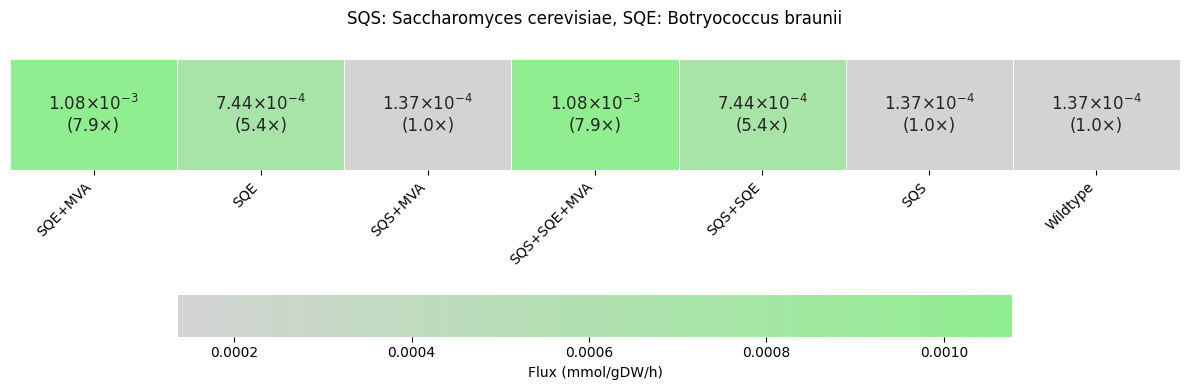

ERG Flux Summary:
  Mean: 0.000579 mmol/gDW/h
  Max:  0.001077 mmol/gDW/h (SQE+MVA)
  Min:  0.000137 mmol/gDW/h (SQS+MVA)
  Std:  0.000403 mmol/gDW/h


In [242]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract ERG flux data for heatmap visualization
def create_erg_flux_heatmap(pathway_df):
    """
    Create a heatmap visualization of ERG reaction flux across different constructs
    """
    print("=== ERG FLUX HEATMAP VISUALIZATION ===\n")
    
    # Check if pathway_df exists and has ERG column
    if pathway_df.empty or 'ERG' not in pathway_df.columns:
        print("No ERG flux data available for visualization")
        return
    
    # Prepare data for heatmap
    # Extract model names and ERG flux values
    models = pathway_df['Model'].tolist()
    # Remove "_updated" suffix from model names
    models = [model.replace('_updated', '') for model in models]
    erg_fluxes = pathway_df['ERG'].tolist()
    
    # Convert to numpy array and reshape for heatmap (single row)
    heatmap_data = np.array(erg_fluxes).reshape(1, -1)
    
    # Create figure and axis
    plt.figure(figsize=(12, 4))
    
    # Create custom colormap from light gray to light green
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['#D3D3D3', '#90EE90']  # Light gray to light green
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
    
    # Find the Wildtype flux for comparison
    wildtype_flux = None
    for i, model in enumerate(models):
        if model.lower() == 'wildtype':
            wildtype_flux = erg_fluxes[i]
            break
    
    # Create custom annotations with 10^n notation and wildtype multipliers
    annotations = []
    for i, flux in enumerate(erg_fluxes):
        # Convert to scientific notation to get the exponent
        sci_str = f"{flux:.2e}"
        # Parse the scientific notation
        mantissa, exp_part = sci_str.split('e')
        exponent = int(exp_part)
        mantissa_val = float(mantissa)
        
        # Format as mantissa × 10^exponent with superscript
        if exponent == 0:
            # If exponent is 0, just show the number
            flux_str = f"{mantissa_val:.2f}"
        else:
            # Use matplotlib's mathtext for superscripts
            flux_str = f"{mantissa_val:.2f}×10$^{{{exponent}}}$"
        
        # Calculate multiplier relative to wildtype
        if wildtype_flux is not None and wildtype_flux != 0:
            multiplier = flux / wildtype_flux
            multiplier_str = f"({multiplier:.1f}×)"
        else:
            multiplier_str = ""
        
        # Combine flux value and multiplier
        formatted = f"{flux_str}\n{multiplier_str}"
        annotations.append(formatted)
    
    # Reshape annotations for heatmap (single row)
    annotations_array = np.array(annotations).reshape(1, -1)
    
    # Create heatmap
    ax = sns.heatmap(
        heatmap_data,
        xticklabels=models,
        yticklabels=False,
        annot=annotations_array,
        fmt='',
        cmap=custom_cmap,
        cbar_kws={'label': 'Flux (mmol/gDW/h)', 'orientation': 'horizontal', 'pad': 0.45},
        linewidths=0.5,
        linecolor='white',
        square=False,
        annot_kws={'size': 12}
    )
    
    # Customize the plot
    plt.title(f'SQS: {mode["sqs"]}, SQE: {mode["sqe"]}', 
              fontsize=12, fontweight='regular', pad=25)
    plt.xlabel('')
    plt.ylabel('', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the plot
    save_dir = os.path.join('..', 'results', 'gecko', 'iter2', f'sqs={mode["sqs"]}', f'sqe={mode["sqe"]}')
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, 'erg_flux_heatmap.png'), dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.savefig(save_path, dpi=300)
    plt.show()
    
    # Print summary statistics
    print(f"ERG Flux Summary:")
    print(f"  Mean: {np.mean(erg_fluxes):.6f} mmol/gDW/h")
    print(f"  Max:  {np.max(erg_fluxes):.6f} mmol/gDW/h ({models[np.argmax(erg_fluxes)]})")
    print(f"  Min:  {np.min(erg_fluxes):.6f} mmol/gDW/h ({models[np.argmin(erg_fluxes)]})")
    print(f"  Std:  {np.std(erg_fluxes):.6f} mmol/gDW/h")

# Create the heatmap visualization
if 'pathway_df' in locals() and not pathway_df.empty:
    create_erg_flux_heatmap(pathway_df)
else:
    print("No pathway flux data available. Please run the optimization first.")